**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on January 22, 2020

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb

## Set up the statsbombloader

In [6]:
# Use this if you only want to use the free public statsbomb data
# free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
# SBL = statsbomb.StatsBombLoader(root=free_open_data_remote,getter="remote")

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
datafolder = "../data-epl" # Example of local folder with statsbomb data
SBL = statsbomb.StatsBombLoader(root=datafolder,getter="local")

## Select competitions to load and convert

In [7]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'La Liga', 'Premier League'}

In [8]:
# Fifa world cup
selected_competitions = competitions[competitions.competition_name=="Premier League"]

# # Messi data
# selected_competitions = competitions[competitions.competition_name=="La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name=="FA Women's Super League"]

selected_competitions

,competition_gender,competition_id,competition_name,country_name,match_available,match_updated,season_id,season_name
13,male,2,Premier League,England,2019-09-04T17:30:39.034,2019-09-04T17:30:39.034,1,2017/2018


In [9]:
# Get matches from all selected competitions
matches = list(
    SBL.matches(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
matches = pd.concat(matches, sort=True).reset_index(drop=True)
matches[["home_team_name","away_team_name","match_date","home_score","away_score"]]

,home_team_name,away_team_name,match_date,home_score,away_score
0,Everton,Swansea City,2017-12-18,3,1
1,Newcastle United,Leicester City,2017-12-09,2,3
2,Watford,West Bromwich Albion,2018-03-03,1,0
3,Swansea City,Burnley,2018-02-10,1,0
4,Leicester City,Stoke City,2018-02-24,1,1
5,Manchester City,West Ham United,2017-12-03,2,1
6,Tottenham Hotspur,West Ham United,2018-01-04,1,1
7,Huddersfield Town,Arsenal,2018-05-13,0,1
8,AFC Bournemouth,Swansea City,2018-05-05,1,0
9,Everton,West Bromwich Albion,2018-01-20,1,1


## Load and convert match data

In [10]:
matches_verbose = tqdm.tqdm(list(matches.itertuples()),desc="Loading match data")
teams,players,player_games = [],[],[]
actions = {}
for match in matches_verbose:
    # load data
    teams.append(SBL.teams(match.match_id))
    players.append(SBL.players(match.match_id))
    events = SBL.events(match.match_id)
    
    # convert data
    player_games.append(statsbomb.extract_player_games(events))
    actions[match.match_id] = statsbomb.convert_to_actions(events,match.home_team_id)

games = matches.rename(columns={"match_id":"game_id"})
teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).drop_duplicates("player_id").reset_index(drop=True)
player_games = pd.concat(player_games).reset_index(drop=True)

Loading match data: 100%|██████████| 380/380 [06:04<00:00,  1.28s/it]


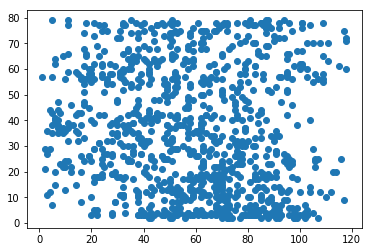

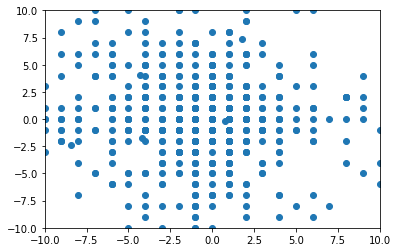

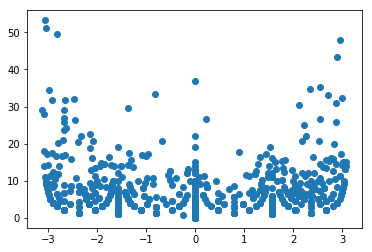

In [38]:
import matplotlib.pyplot as plt
import numpy as np

carries = events[events.type_name == "Carry"]
x = np.array([l[0] for l in carries.location])
y = np.array([l[1] for l in carries.location])
plt.scatter(x,y)
plt.show()
ls = [c["carry"]["end_location"] for c in carries.extra]
ex = np.array([l[0] for l in ls])
ey = np.array([l[1] for l in ls])
a = pd.DataFrame()
a["dx"] = x - ex
a["dy"] = y - ey
plt.scatter(a.dx, a.dy)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

def movement_polar(actions):
    mov = pd.DataFrame()
    mov["mov_d"] = np.sqrt(actions.dx ** 2 + actions.dy ** 2)
    with np.errstate(divide="ignore", invalid="ignore"):
        mov["mov_angle"] = np.arctan2(actions.dy,actions.dx)
        mov.loc[actions.dy == 0,"mov_angle"] = 0 # fix float errors
    return mov

po = movement_polar(a)
plt.scatter(po.mov_angle,po.mov_d)
#plt.ylim(10,50)
plt.show()

## Store converted spadl data in a h5-file

In [11]:
datafolder = "../data-epl"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players
    spadlstore["player_games"] = player_games
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        
    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [11]:
# Select England vs Belgium game at World Cup
with pd.HDFStore(spadl_h5) as spadlstore:
    games = spadlstore["games"].merge(spadlstore["competitions"])
    game_id = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")].game_id.values[0]
    actions = spadlstore[f"actions/game_{game_id}"]
    actions = (
        actions.merge(spadlstore["actiontypes"],how="left")
        .merge(spadlstore["results"],how="left")
        .merge(spadlstore["bodyparts"],how="left")
        .merge(spadlstore["players"],how="left")
        .merge(spadlstore["teams"],how="left")
    )

# use nickname if available else use full name
actions["player"] = actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
actions[:5]

,game_id,period_id,time_seconds,timestamp,team_id,player_id,start_x,start_y,end_x,end_y,...,result_name,bodypart_name,player_name,player_nickname,jersey_number,country_id,country_name,extra,team_name,player
0,8657,1,0.0,00:00:00.533,782,3289,52.941176,33.569620,44.117647,33.569620,...,success,foot,Romelu Lukaku Menama,Romelu Lukaku,9,22,Belgium,{},Belgium,Romelu Lukaku
1,8657,1,1.0,00:00:01.252,782,5642,44.117647,33.569620,44.117647,34.430380,...,success,foot,Axel Witsel,None,6,22,Belgium,{},Belgium,Axel Witsel
2,8657,1,2.0,00:00:02.133,782,5642,44.117647,34.430380,31.764706,53.367089,...,success,foot,Axel Witsel,None,6,22,Belgium,{},Belgium,Axel Witsel
3,8657,1,3.0,00:00:03.732,782,3077,31.764706,53.367089,28.235294,53.367089,...,success,foot,Jan Vertonghen,None,5,22,Belgium,{},Belgium,Jan Vertonghen
4,8657,1,4.0,00:00:04.933,782,3077,28.235294,53.367089,23.823529,38.734177,...,success,foot,Jan Vertonghen,None,5,22,Belgium,{},Belgium,Jan Vertonghen


2018-07-14 Belgium 2-0 England 82'


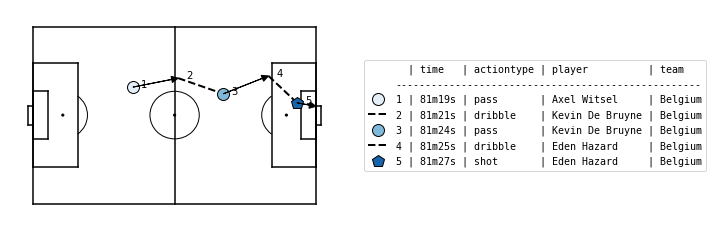

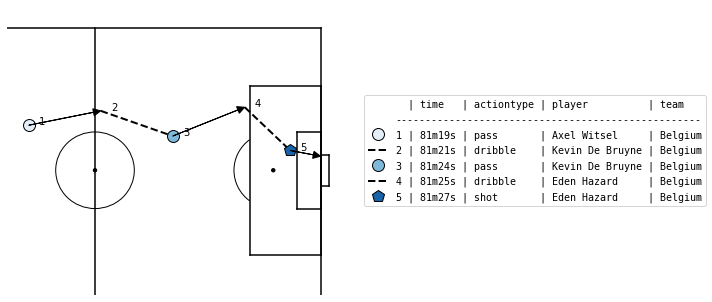

In [13]:
import matplotsoccer

shot = 2201
a = actions[shot-4:shot+1].copy()

g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60)
game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "player", "team_name"]]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=False,
    figsize=6
)
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team=a.team_name,
    result=a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=True,
)